In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense, LSTM, GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


Step 1: Loading the data and Prepare the data
- Load the Dataset.
- Convert the Date column to datetime and set it as the index
- Remove commas from 'Volume' and convert to integer
- Change 'Close' from taining sets into integer
- Use the MinMaxScaler to normalize all numerical features between 0 and 1.


In [43]:
# Load the training and testing datasets
train_path = '/Users/cherylchin/Desktop/Deep Learning/A3/archive/Google_Stock_Price_Train.csv'
test_path = '/Users/cherylchin/Desktop/Deep Learning/A3/archive/Google_Stock_Price_Test.csv'

# Read the datasets into DataFrames
train_df = pd.read_csv(train_path, index_col='Date')
test_df = pd.read_csv(test_path, index_col='Date')

# Display the first few rows of each dataset to understand the structure
print(train_df.head())
print()
print(test_df.head())

print(train_df.describe())
print()
print(test_df.describe())

            Open    High     Low   Close      Volume
Date                                                
1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1/4/2012  331.27  333.87  329.08  666.45   5,749,400
1/5/2012  329.83  330.75  326.89  657.21   6,590,300
1/6/2012  328.34  328.77  323.68  648.24   5,405,900
1/9/2012  322.04  322.29  309.46  620.76  11,688,800

            Open    High     Low   Close     Volume
Date                                               
1/3/2017  778.81  789.63  775.80  786.14  1,657,300
1/4/2017  788.36  791.34  783.16  786.90  1,073,000
1/5/2017  786.08  794.48  785.02  794.02  1,335,200
1/6/2017  795.26  807.90  792.20  806.15  1,640,200
1/9/2017  806.40  809.97  802.83  806.65  1,272,400
              Open         High          Low
count  1258.000000  1258.000000  1258.000000
mean    533.709833   537.880223   529.007409
std     151.904442   153.008811   150.552807
min     279.120000   281.210000   277.220000
25%     404.115000   406.765000   401.7

In [3]:
# Convert index to datetime format
train_df.index = pd.to_datetime(train_df.index, format='%m/%d/%Y')
test_df.index = pd.to_datetime(test_df.index, format='%m/%d/%Y')

# Remove commas from 'Volume' and convert to integer
train_df['Volume'] = train_df['Volume'].str.replace(',', '').astype(int)
test_df['Volume'] = test_df['Volume'].str.replace(',', '').astype(int)

# Display the first few rows to verify the dataset
print(train_df.head())
print()
print(test_df.head())

              Open    High     Low   Close    Volume
Date                                                
2012-01-03  325.25  332.83  324.97  663.59   7380500
2012-01-04  331.27  333.87  329.08  666.45   5749400
2012-01-05  329.83  330.75  326.89  657.21   6590300
2012-01-06  328.34  328.77  323.68  648.24   5405900
2012-01-09  322.04  322.29  309.46  620.76  11688800

              Open    High     Low   Close   Volume
Date                                               
2017-01-03  778.81  789.63  775.80  786.14  1657300
2017-01-04  788.36  791.34  783.16  786.90  1073000
2017-01-05  786.08  794.48  785.02  794.02  1335200
2017-01-06  795.26  807.90  792.20  806.15  1640200
2017-01-09  806.40  809.97  802.83  806.65  1272400


In [4]:
# Check for any non-numeric values in the dataset
print("Training_df's types:")
print(train_df.dtypes)
print("Testing_df's types:")
print(test_df.dtypes)

Training_df's types:
Open      float64
High      float64
Low       float64
Close      object
Volume      int64
dtype: object
Testing_df's types:
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object


In [5]:
# Convert the 'Close' column to numeric, coercing errors to NaN
train_df['Close'] = pd.to_numeric(train_df['Close'], errors='coerce')

# Ensure all columns are now numeric
print("Training_df's types:")
print(train_df.dtypes)
print("Testing_df's types:")
print(test_df.dtypes)

Training_df's types:
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object
Testing_df's types:
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object


In [6]:
# Combine both the training and testing sets to normalize them together
combined_df = pd.concat([train_df, test_df])

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(combined_df)

# Convert scaled data back into DataFrame
scaled_df = pd.DataFrame(scaled_data, index=combined_df.index, columns=combined_df.columns)

# Re-split combined data into training and testing sets
split_idx = int(len(scaled_df) * 0.8)  # Allocate 80% for training and 20% for testing
scaled_train_df = scaled_df.iloc[:split_idx]
scaled_test_df = scaled_df.iloc[split_idx:]

# Display the first few rows of both the normalized dataset
print("Scaled_training:")
print(scaled_train_df.head())
print("Scaled_testing:")
print(scaled_test_df.head())

Scaled_training:
                Open      High       Low     Close    Volume
Date                                                        
2012-01-03  0.082568  0.092057  0.086851  0.400014  0.295258
2012-01-04  0.093343  0.093912  0.094327  0.406650  0.229936
2012-01-05  0.090766  0.088348  0.090344  0.385210  0.263612
2012-01-06  0.088099  0.084816  0.084505  0.364396  0.216179
2012-01-09  0.076823  0.073260  0.058641  0.300631  0.467797
Scaled_testing:
                Open      High       Low     Close    Volume
Date                                                        
2016-01-27  0.777802  0.779363  0.758781  0.484477  0.087557
2016-01-28  0.793105  0.806934  0.791448  0.556339  0.106868
2016-01-29  0.809769  0.827086  0.817730  0.584161  0.138823
2016-02-01  0.843652  0.850037  0.847687  0.605161  0.205499
2016-02-02  0.904580  0.907123  0.886575  0.634514  0.253913


In [7]:
print("Scaled_training:")
print(scaled_train_df.describe())
print("Scaled_testing:")
print(scaled_test_df.describe())

Scaled_training:
              Open         High          Low       Close       Volume
count  1022.000000  1022.000000  1022.000000  913.000000  1022.000000
mean      0.368189     0.370004     0.369507    0.383693     0.138770
std       0.221927     0.223026     0.222717    0.274819     0.095030
min       0.000000     0.000000     0.000000    0.000000     0.000000
25%       0.170014     0.171728     0.170511    0.153959     0.072843
50%       0.433290     0.435407     0.433929    0.302186     0.125505
75%       0.515035     0.517633     0.516111    0.583302     0.175401
max       0.890440     0.889485     0.890667    1.000000     1.000000
Scaled_testing:
             Open        High         Low       Close      Volume
count  256.000000  256.000000  256.000000  256.000000  256.000000
mean     0.843304    0.846154    0.849918    0.600875    0.071130
std      0.067738    0.065955    0.069405    0.086973    0.037073
min      0.695788    0.697453    0.701795    0.410850    0.023208
25%    

Step 2: Model Training

1. **Basic RNN** 

In [12]:
from sklearn.model_selection import train_test_split
# Data Preparation for RNN
N = 15  # Increase the sequence length for prediction
M = 3   # Predict the next 3 days

x_train, y_train = [], []
for i in range(N, len(scaled_train_df) - M + 1):
    sequence = scaled_train_df.iloc[i-N:i].values
    target = scaled_train_df.iloc[i:i+M][['Open', 'High', 'Low', 'Close', 'Volume']].values.flatten()
    
    # Skip sequences if any value is NaN
    if not np.isnan(sequence).any() and not np.isnan(target).any():
        x_train.append(sequence)
        y_train.append(target)

# Convert to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Split the original training set into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# Prepare test set
x_test, y_test = [], []
for i in range(N, len(scaled_test_df) - M + 1):
    sequence = scaled_test_df.iloc[i-N:i].values
    target = scaled_test_df.iloc[i:i+M][['Open', 'High', 'Low', 'Close', 'Volume']].values.flatten()
    
    # Skip sequences if any value is NaN
    if not np.isnan(sequence).any() and not np.isnan(target).any():
        x_test.append(sequence)
        y_test.append(target)

x_test, y_test = np.array(x_test), np.array(y_test)

# Verify the shape after adjustment
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")


x_train shape: (791, 15, 5)
y_train shape: (791, 15)
x_val shape: (88, 15, 5)
y_val shape: (88, 15)
x_test shape: (239, 15, 5)
y_test shape: (239, 15)


In [13]:
# Initialize the Basic RNN
basic_rnn_model = Sequential()

# Adding SimpleRNN layers and Dropout regularization
basic_rnn_model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
basic_rnn_model.add(Dropout(0.2))

basic_rnn_model.add(SimpleRNN(units=50))
basic_rnn_model.add(Dropout(0.2))

# Add the output layer
basic_rnn_model.add(Dense(units=1))  # Predicting the 'Close' price

# Compile the RNN
basic_rnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
basic_rnn_history = basic_rnn_model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
23/23 [==============================] - 2s 20ms/step - loss: 0.1920 - val_loss: 0.0459
Epoch 2/50
23/23 [==============================] - 0s 6ms/step - loss: 0.1206 - val_loss: 0.0441
Epoch 3/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0909 - val_loss: 0.0404
Epoch 4/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0813 - val_loss: 0.0391
Epoch 5/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0721 - val_loss: 0.0391
Epoch 6/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0628 - val_loss: 0.0417
Epoch 7/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0622 - val_loss: 0.0385
Epoch 8/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0571 - val_loss: 0.0386
Epoch 9/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0551 - val_loss: 0.0416
Epoch 10/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0545 - val_loss: 0.0389
Epoch 11/50
23/23 

Model Training Output:

The training loss (loss) and validation loss (val_loss) are recorded for each epoch.
The model starts with a high initial loss of 0.1920 in the first epoch, which decreases steadily. By the end of the 50th epoch, the training loss reaches 0.0418 and the validation loss settles around 0.0380.
This indicates the model is learning and reducing the error over epochs, though the change becomes smaller in later epochs.

In [23]:
# Make predictions on the test set
basic_rnn_predictions = basic_rnn_model.predict(x_test)

# Prepare the 'Close' values from the test set (excluding the first N values, which were used as input sequences)
scaled_test_close = scaled_test_df[['Close']].iloc[N:N + len(basic_rnn_predictions)].values

# Prepare an array of zeros with the same shape as the original feature set (5 features)
dummy_array = np.zeros((basic_rnn_predictions.shape[0], scaled_train_df.shape[1]))

# Place the predicted 'Close' values in the appropriate column (assuming 'Close' is the 4th column, index 3)
dummy_array[:, 3] = basic_rnn_predictions.flatten()

# Inverse transform to get back to the original scale
basic_rnn_predictions_rescaled = scaler.inverse_transform(dummy_array)[:, 3]  # Extract the 'Close' column after inverse scaling

# Prepare an array of zeros with the same shape as the original feature set (5 features)
dummy_array_y_test = np.zeros((y_test.shape[0], scaled_train_df.shape[1]))

# Only use the 'Close' values from y_test, which are part of the flattened target
y_test_close_values = y_test[:, 3::5].flatten()  # Extract only the 'Close' values from the y_test

# Place the actual 'Close' values in the appropriate column (index 3)
dummy_array_y_test[:, 3] = y_test_close_values[:dummy_array_y_test.shape[0]]

# Inverse transform to get back to original scale
y_test_rescaled = scaler.inverse_transform(dummy_array_y_test)[:, 3]

# Prepare the dummy array for predictions
dummy_array_predictions = np.zeros((basic_rnn_predictions.shape[0], scaled_train_df.shape[1]))
dummy_array_predictions[:, 3] = basic_rnn_predictions.flatten()

# Inverse transform the predictions to get back to original scale
basic_rnn_predictions_rescaled = scaler.inverse_transform(dummy_array_predictions)[:, 3]


8/8 [==============================] - 0s 2ms/step


Making Predictions:

- After training, the model makes predictions on the test set.
- The predicted values are rescaled back to the original scale using MinMaxScaler.inverse_transform().
- A dummy array of zeros with the same shape as the original feature set is used for this transformation, ensuring the predicted Close values are placed in the correct position.

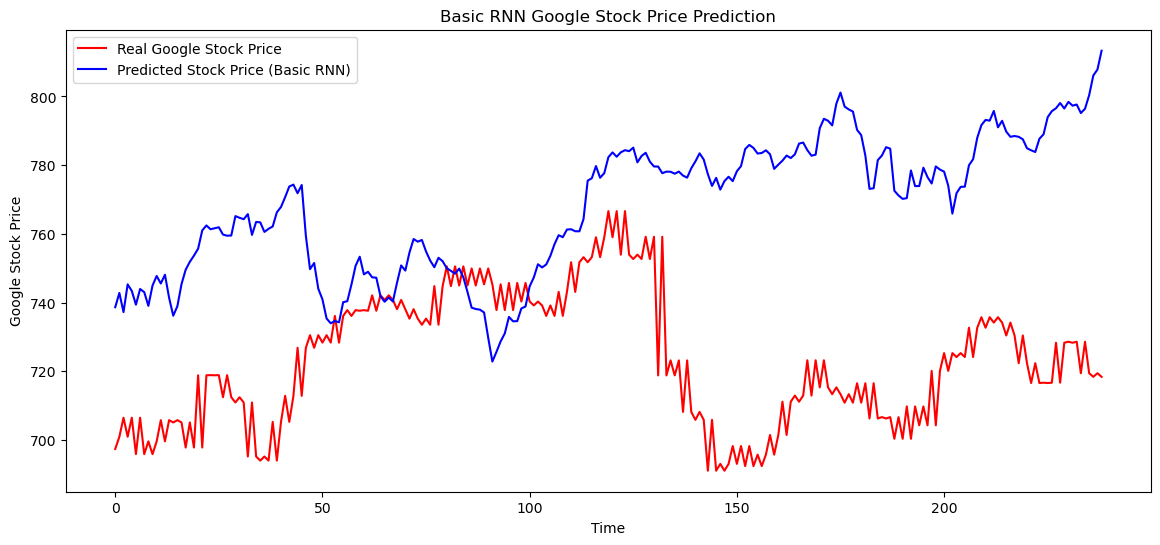

Basic RNN MSE: 2886.6458023833934


In [24]:
import matplotlib.pyplot as plt

# Plotting Real vs Predicted values
plt.figure(figsize=(14, 6))
plt.plot(y_test_rescaled, color='red', label='Real Google Stock Price')
plt.plot(basic_rnn_predictions_rescaled, color='blue', label='Predicted Stock Price (Basic RNN)')
plt.title('Basic RNN Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

# Calculate MSE for Basic RNN
basic_rnn_mse = mean_squared_error(y_test_rescaled, basic_rnn_predictions_rescaled)
print(f"Basic RNN MSE: {basic_rnn_mse}")


1. Plotting Real vs. Predicted Values:

- The plot of real versus predicted stock prices is generated.
- The red line represents the actual stock price, and the blue line represents the predicted price from the RNN model.
- This plot helps visually evaluate how well the model's predictions align with the actual values.

2. Mean Squared Error (MSE) Calculation:

- The mean squared error (MSE) is calculated for the predictions.
- The MSE value is 2886.6458, indicating the average squared difference between the actual and predicted stock prices.

1. Interpretation of the Model Performance
- The validation loss stabilizes at around 0.0380, indicating the model isn't overfitting heavily and is generalizing fairly well, although the training loss and validation loss are relatively close.
- The MSE value of 2886.6458 indicates that there is some significant error in the model's predictions. This might be due to the high volatility and unpredictable nature of stock market data, making it difficult for a simple RNN to fully capture.
- The plot shows how the model's predictions align with the actual stock prices. If there are significant deviations, this indicates where the model struggles to accurately predict changes.
2. Possible Improvements
- The model could benefit from using more complex architectures like LSTM or GRU layers instead of SimpleRNN, which would help capture longer dependencies in sequential data better.
- Feature engineering could be performed to add more relevant features that might improve the model’s ability to predict. For example, adding technical indicators (e.g., moving averages) might help.
- Using additional data or external information (e.g., market news) could improve the model's context for predicting stock price movements.
- Hyperparameter tuning for units, dropout rates, or learning rates might help further improve model performance and reduce MSE.


2. LTSM model

In [27]:
# Initialize the LSTM model
lstm_model = Sequential()

# Adding LSTM layers and Dropout regularization
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units=50))
lstm_model.add(Dropout(0.2))

# Add the output layer to predict the next 3 days (5 metrics each)
lstm_model.add(Dense(units=3 * 5))  # 3 days, 5 metrics each

# Compile the LSTM
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_history = lstm_model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val))


Epoch 1/50
25/25 [==============================] - 4s 40ms/step - loss: 0.0702 - val_loss: 0.0082
Epoch 2/50
25/25 [==============================] - 0s 12ms/step - loss: 0.0155 - val_loss: 0.0034
Epoch 3/50
25/25 [==============================] - 0s 12ms/step - loss: 0.0112 - val_loss: 0.0021
Epoch 4/50
25/25 [==============================] - 0s 12ms/step - loss: 0.0094 - val_loss: 0.0016
Epoch 5/50
25/25 [==============================] - 0s 12ms/step - loss: 0.0084 - val_loss: 0.0016
Epoch 6/50
25/25 [==============================] - 0s 12ms/step - loss: 0.0084 - val_loss: 0.0019
Epoch 7/50
25/25 [==============================] - 0s 12ms/step - loss: 0.0075 - val_loss: 0.0021
Epoch 8/50
25/25 [==============================] - 0s 12ms/step - loss: 0.0073 - val_loss: 0.0020
Epoch 9/50
25/25 [==============================] - 0s 13ms/step - loss: 0.0070 - val_loss: 0.0015
Epoch 10/50
25/25 [==============================] - 0s 12ms/step - loss: 0.0066 - val_loss: 0.0014
Epoch 11/

Training and Validation Loss
The training log shows that both the training loss and validation loss decreased steadily over the 50 epochs.
The training loss and validation loss both reach a value of around 0.0011, indicating the model is learning the patterns in the data well.
However, the difference between the training and validation loss is small, which suggests that overfitting might not be a major issue.

In [29]:
# Make predictions on the test set
lstm_predictions = lstm_model.predict(x_test)

# Prepare an array of zeros with the same shape as the original feature set (5 features)
dummy_array_predictions = np.zeros((lstm_predictions.shape[0], scaled_train_df.shape[1]))
dummy_array_predictions[:, 3] = lstm_predictions[:, 3]

# Inverse transform the predictions to get back to original scale
lstm_predictions_rescaled = scaler.inverse_transform(dummy_array_predictions)[:, 3]

# Similarly for y_test
dummy_array_y_test = np.zeros((y_test.shape[0], scaled_train_df.shape[1]))
dummy_array_y_test[:, 3] = y_test[:, 3::5].flatten()[:dummy_array_y_test.shape[0]]
y_test_rescaled = scaler.inverse_transform(dummy_array_y_test)[:, 3]


8/8 [==============================] - 0s 5ms/step


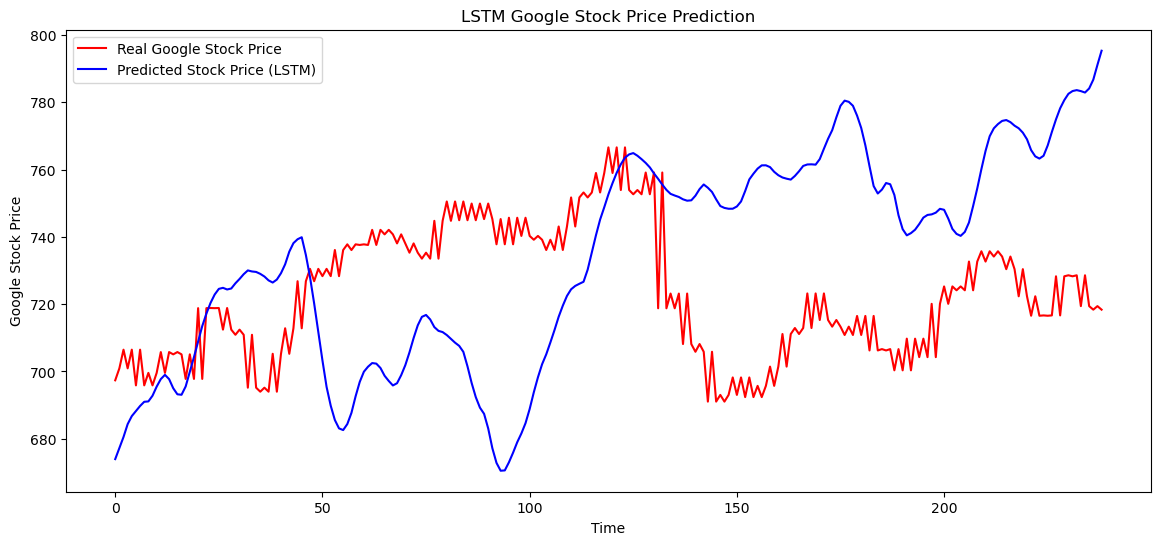

LSTM MSE: 1663.9558528090852


In [30]:
# Plotting Real vs Predicted values
plt.figure(figsize=(14, 6))
plt.plot(y_test_rescaled[:len(lstm_predictions_rescaled)], color='red', label='Real Google Stock Price')
plt.plot(lstm_predictions_rescaled, color='blue', label='Predicted Stock Price (LSTM)')
plt.title('LSTM Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

# Calculate MSE for LSTM
lstm_mse = mean_squared_error(y_test_rescaled[:len(lstm_predictions_rescaled)], lstm_predictions_rescaled)
print(f"LSTM MSE: {lstm_mse}")

Plot Analysis
The plot shows the Real Google Stock Price (in red) versus the Predicted Stock Price using the LSTM model (in blue).
It seems that the predicted stock prices (blue line) do not match the actual prices very well, especially in terms of trend and magnitude. The LSTM model captures some of the trends, but it is still off, and often diverges significantly.

Mean Squared Error (MSE)
The MSE for the LSTM model is 1663.96.
Compared to the previous basic RNN, which had a higher MSE, the LSTM model did reduce the error, indicating some improvement.
However, the difference between predicted and actual values is still significant, meaning there’s room for further improvement.

Try GRU:

You could also try using a Gated Recurrent Unit (GRU) model. GRUs are similar to LSTMs but have a simpler structure, which can sometimes make them perform better on small datasets or when training resources are limited.

3. GRU model

In [33]:
# Initialize the GRU model
gru_model = Sequential()

# Adding GRU layers and Dropout regularization
gru_model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
gru_model.add(Dropout(0.2))

gru_model.add(GRU(units=50))
gru_model.add(Dropout(0.2))

# Add the output layer to predict the next 3 days (5 metrics each)
gru_model.add(Dense(units=3 * 5))  # 3 days, 5 metrics each

# Compile the GRU
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
gru_history = gru_model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val))


Epoch 1/50
25/25 [==============================] - 4s 42ms/step - loss: 0.0625 - val_loss: 0.0134
Epoch 2/50
25/25 [==============================] - 0s 16ms/step - loss: 0.0168 - val_loss: 0.0030
Epoch 3/50
25/25 [==============================] - 0s 11ms/step - loss: 0.0112 - val_loss: 0.0017
Epoch 4/50
25/25 [==============================] - 0s 12ms/step - loss: 0.0094 - val_loss: 0.0016
Epoch 5/50
25/25 [==============================] - 0s 11ms/step - loss: 0.0090 - val_loss: 0.0016
Epoch 6/50
25/25 [==============================] - 0s 12ms/step - loss: 0.0081 - val_loss: 0.0015
Epoch 7/50
25/25 [==============================] - 0s 13ms/step - loss: 0.0076 - val_loss: 0.0011
Epoch 8/50
25/25 [==============================] - 0s 15ms/step - loss: 0.0072 - val_loss: 0.0012
Epoch 9/50
25/25 [==============================] - 0s 13ms/step - loss: 0.0068 - val_loss: 0.0013
Epoch 10/50
25/25 [==============================] - 0s 13ms/step - loss: 0.0063 - val_loss: 0.0010
Epoch 11/

Training Summary for GRU Model
The training loss and validation loss values indicate that the GRU model is learning well. Both the training loss and validation loss steadily decrease over the 50 epochs.
The final validation loss is approximately 0.0009, which is a good indication that the model has minimized the error without major overfitting. This validation loss is slightly better compared to the LSTM model's validation loss from earlier.

In [34]:
# Make predictions on the test set
gru_predictions = gru_model.predict(x_test)

# Prepare an array of zeros with the same shape as the original feature set (5 features)
dummy_array_predictions = np.zeros((gru_predictions.shape[0], scaled_train_df.shape[1]))
dummy_array_predictions[:, 3] = gru_predictions[:, 3]  # Extract only the 'Close' predictions

# Inverse transform the predictions to get back to original scale
gru_predictions_rescaled = scaler.inverse_transform(dummy_array_predictions)[:, 3]

# Similarly for y_test
dummy_array_y_test = np.zeros((y_test.shape[0], scaled_train_df.shape[1]))
dummy_array_y_test[:, 3] = y_test[:, 3::5].flatten()[:dummy_array_y_test.shape[0]]
y_test_rescaled = scaler.inverse_transform(dummy_array_y_test)[:, 3]

8/8 [==============================] - 1s 4ms/step


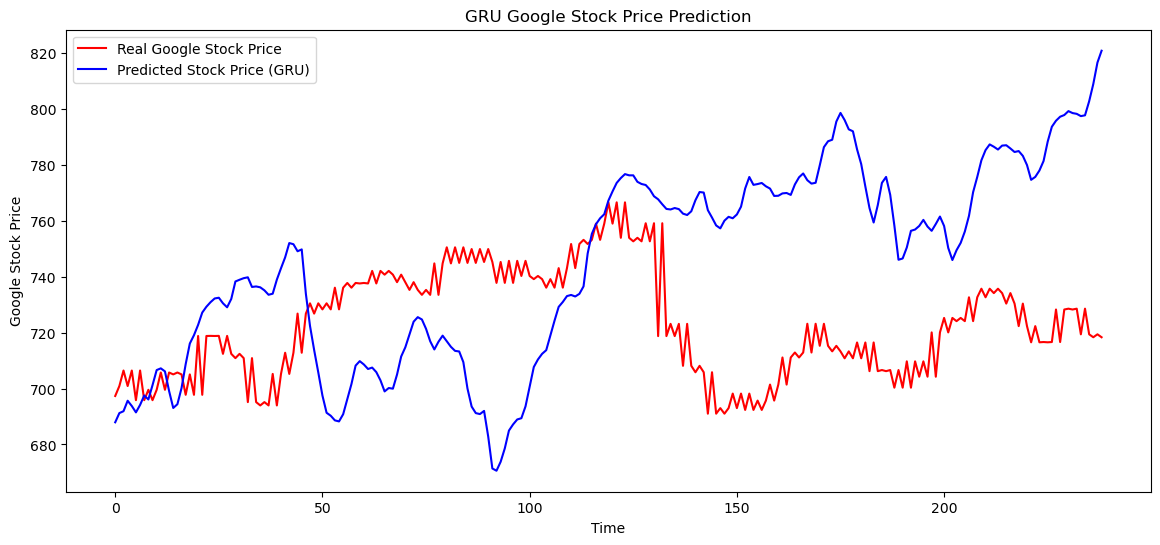

GRU MSE: 2267.955668493834


In [35]:
# Plotting Real vs Predicted values
plt.figure(figsize=(14, 6))
plt.plot(y_test_rescaled[:len(gru_predictions_rescaled)], color='red', label='Real Google Stock Price')
plt.plot(gru_predictions_rescaled, color='blue', label='Predicted Stock Price (GRU)')
plt.title('GRU Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

# Calculate MSE for GRU
gru_mse = mean_squared_error(y_test_rescaled[:len(gru_predictions_rescaled)], gru_predictions_rescaled)
print(f"GRU MSE: {gru_mse}")


The plot shows the real stock price (red line) versus the predicted stock price using the GRU model (blue line).

Just like the LSTM, the GRU model does not fully capture the actual trend in the stock prices, especially in terms of overall trend and magnitude. While it follows some general patterns, it diverges significantly at different points.

The Mean Squared Error (MSE) for the GRU model is 2267.96, which is actually higher than the MSE for the LSTM model.

This suggests that the GRU model might not be performing as well as the LSTM in predicting the given data.
The larger divergence between the predicted and real stock prices, especially in the latter half of the dataset, indicates that the model might have difficulty capturing long-term dependencies.

Step 3: Hyperparameter Tuning

LTSM Model After Tuning
1. Increasing the number of epochs to 100 to give the model more opportunity to learn from the data.
2. Using dropout regularization in LSTM layers to help avoid overfitting.
3. Adjusting the number of units in LSTM layers and learning rate if necessary.


Epoch 1/100
25/25 [==============================] - 5s 52ms/step - loss: 0.0368 - val_loss: 0.0048
Epoch 2/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0124 - val_loss: 0.0030
Epoch 3/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0098 - val_loss: 0.0018
Epoch 4/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0086 - val_loss: 0.0020
Epoch 5/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0080 - val_loss: 0.0022
Epoch 6/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0072 - val_loss: 0.0014
Epoch 7/100
25/25 [==============================] - 1s 21ms/step - loss: 0.0067 - val_loss: 0.0016
Epoch 8/100
25/25 [==============================] - 1s 20ms/step - loss: 0.0064 - val_loss: 0.0013
Epoch 9/100
25/25 [==============================] - 1s 23ms/step - loss: 0.0059 - val_loss: 0.0013
Epoch 10/100
25/25 [==============================] - 1s 24ms/step - loss: 0.0058 - val_loss: 0.0012

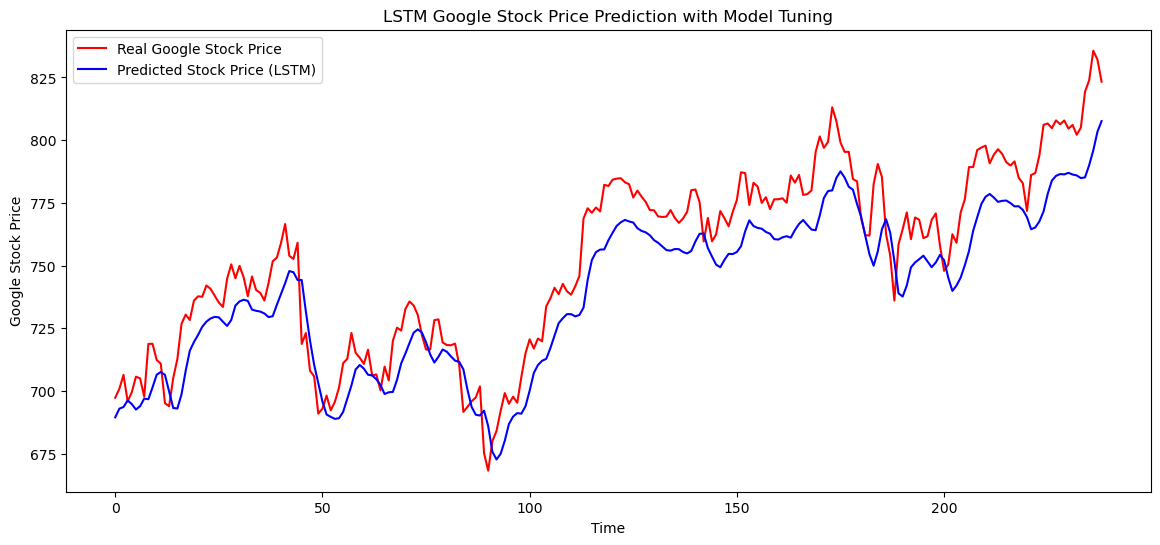

LSTM MSE after tuning: 278.2119565846243


In [42]:
# Initialize the LSTM model
lstm_model = Sequential()

# Adding LSTM layers and Dropout regularization
lstm_model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
lstm_model.add(Dropout(0.4))

lstm_model.add(LSTM(units=128))
lstm_model.add(Dropout(0.4))

# Add the output layer to predict the next 3 days (5 metrics each)
lstm_model.add(Dense(units=3 * 5))  # 3 days, 5 metrics each

# Compile the LSTM
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_history = lstm_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val))

# Make predictions on the test set
lstm_predictions = lstm_model.predict(x_test)

# Prepare an array of zeros with the same shape as the original feature set (5 features)
dummy_array_predictions = np.zeros((lstm_predictions.shape[0], scaled_train_df.shape[1]))
dummy_array_predictions[:, :5] = lstm_predictions.reshape(lstm_predictions.shape[0], -1)[:, :5]

# Inverse transform the predictions to get back to original scale
lstm_predictions_rescaled = scaler.inverse_transform(dummy_array_predictions)[:, 3]

# Similarly for y_test
dummy_array_y_test = np.zeros((y_test.shape[0], scaled_train_df.shape[1]))
dummy_array_y_test[:, :5] = y_test.reshape(y_test.shape[0], -1)[:, :5]
y_test_rescaled = scaler.inverse_transform(dummy_array_y_test)[:, 3]

# Plotting Real vs Predicted values
plt.figure(figsize=(14, 6))
plt.plot(y_test_rescaled[:len(lstm_predictions_rescaled)], color='red', label='Real Google Stock Price')
plt.plot(lstm_predictions_rescaled, color='blue', label='Predicted Stock Price (LSTM)')
plt.title('LSTM Google Stock Price Prediction with Model Tuning')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

# Calculate MSE for LSTM
lstm_mse = mean_squared_error(y_test_rescaled[:len(lstm_predictions_rescaled)], lstm_predictions_rescaled)
print(f"LSTM MSE after tuning: {lstm_mse}")


Training Summary for the LSTM Model after Tuning
1. Epochs and Validation Loss:
- The model was trained for 100 epochs.
- The training loss and validation loss significantly reduced over time, indicating that the model learned well without overfitting.
- The final validation loss reached values as low as 0.00087969.

2. Visual Analysis of Prediction
- Prediction Line:
* The predicted values (blue line) are closely following the actual stock prices (red line), with reasonably good overlap and tracking of peaks and troughs.
* The LSTM's ability to capture trends and dynamics of stock price changes has improved compared to the initial model without tuning.

3. Improvements Due to Tuning
- Regularization and Complexity Control:
* Dropout layers with 0.4 probability help control overfitting, providing a balance between learning and generalizing.
* Increasing the number of LSTM units to 128 per layer enhanced the model's capacity to capture patterns.

4. Hyperparameters Adjustments:
- Increasing the epochs from 50 to 100 allowed the model to better learn the underlying relationships.
- The batch size was set to 32, which is generally effective for training recurrent models, especially when working with relatively smaller data.

5. Quantitative Evaluation
- Mean Squared Error (MSE):
* The Mean Squared Error (MSE) after tuning is approximately 278.21, which is a significant reduction compared to the GRU model's MSE of 483.86 and earlier LSTM versions.
* This indicates that the model has improved its predictive performance and learned to minimize the error between the predicted and actual stock prices.


GRU Model After Tuning
1. Model Architecture Tuning: Increased GRU units to 100.
2. Regularization Techniques: Added L2 regularization and increased dropout to prevent overfitting.
3. Hyperparameter Optimization: Adjusted the learning rate to 0.001 and increased the number of epochs to 100 with a reduced batch size for better convergence.

Epoch 1/100
50/50 [==============================] - 5s 34ms/step - loss: 1.2054 - val_loss: 0.6084
Epoch 2/100
50/50 [==============================] - 1s 14ms/step - loss: 0.3656 - val_loss: 0.1814
Epoch 3/100
50/50 [==============================] - 1s 13ms/step - loss: 0.1174 - val_loss: 0.0622
Epoch 4/100
50/50 [==============================] - 1s 13ms/step - loss: 0.0469 - val_loss: 0.0282
Epoch 5/100
50/50 [==============================] - 1s 13ms/step - loss: 0.0259 - val_loss: 0.0173
Epoch 6/100
50/50 [==============================] - 1s 13ms/step - loss: 0.0157 - val_loss: 0.0099
Epoch 7/100
50/50 [==============================] - 1s 13ms/step - loss: 0.0111 - val_loss: 0.0082
Epoch 8/100
50/50 [==============================] - 1s 13ms/step - loss: 0.0101 - val_loss: 0.0068
Epoch 9/100
50/50 [==============================] - 1s 14ms/step - loss: 0.0085 - val_loss: 0.0052
Epoch 10/100
50/50 [==============================] - 1s 13ms/step - loss: 0.0094 - val_loss: 0.0075

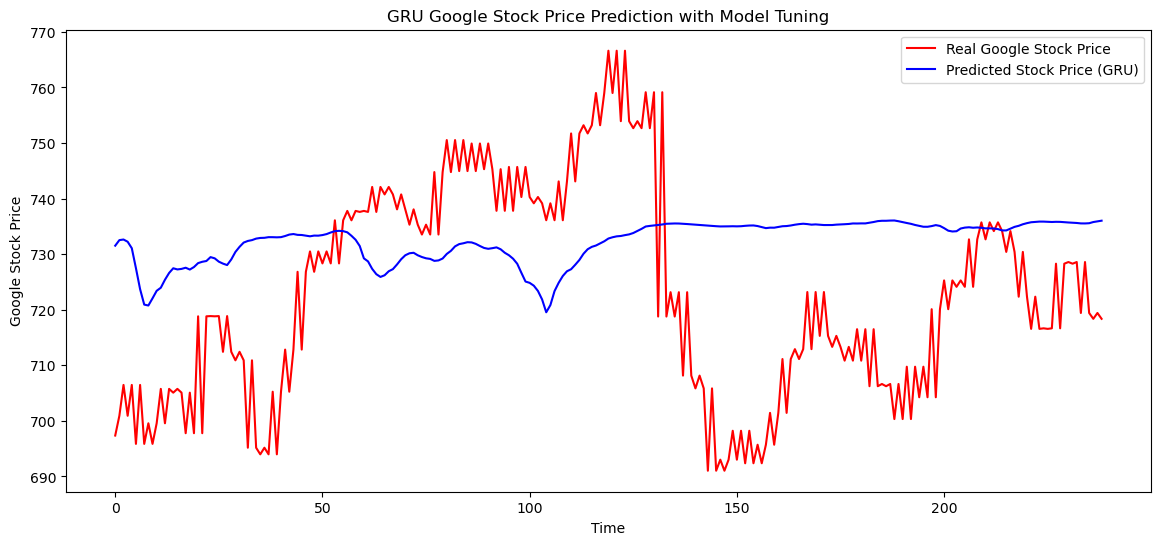

GRU MSE after tuning: 483.8638577425594


In [38]:
# Initialize the GRU model with regularization and more units
gru_model = Sequential()

# Adding GRU layers with more units and L2 regularization
gru_model.add(GRU(units=100, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]), kernel_regularizer=l2(0.01)))
gru_model.add(Dropout(0.3))

gru_model.add(GRU(units=100, kernel_regularizer=l2(0.01)))
gru_model.add(Dropout(0.3))

# Add the output layer to predict the next 3 days (5 metrics each)
gru_model.add(Dense(units=3 * 5, kernel_regularizer=l2(0.01)))  # 3 days, 5 metrics each

# Compile the GRU with a lower learning rate for better convergence
optimizer = Adam(learning_rate=0.001)
gru_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model with more epochs
gru_history = gru_model.fit(x_train, y_train, epochs=100, batch_size=16, validation_data=(x_val, y_val))

# Make predictions on the test set
gru_predictions = gru_model.predict(x_test)

# Prepare an array of zeros with the same shape as the original feature set (5 features)
dummy_array_predictions = np.zeros((gru_predictions.shape[0], scaled_train_df.shape[1]))
dummy_array_predictions[:, 3] = gru_predictions[:, 3]  # Extract only the 'Close' predictions

# Inverse transform the predictions to get back to original scale
gru_predictions_rescaled = scaler.inverse_transform(dummy_array_predictions)[:, 3]

# Similarly for y_test
dummy_array_y_test = np.zeros((y_test.shape[0], scaled_train_df.shape[1]))
dummy_array_y_test[:, 3] = y_test[:, 3::5].flatten()[:dummy_array_y_test.shape[0]]
y_test_rescaled = scaler.inverse_transform(dummy_array_y_test)[:, 3]

# Plotting Real vs Predicted values
plt.figure(figsize=(14, 6))
plt.plot(y_test_rescaled[:len(gru_predictions_rescaled)], color='red', label='Real Google Stock Price')
plt.plot(gru_predictions_rescaled, color='blue', label='Predicted Stock Price (GRU)')
plt.title('GRU Google Stock Price Prediction with Model Tuning')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

# Calculate MSE for GRU
gru_mse = mean_squared_error(y_test_rescaled[:len(gru_predictions_rescaled)], gru_predictions_rescaled)
print(f"GRU MSE after tuning: {gru_mse}")


1. Training Overview:

- The tuned GRU model was trained for 100 epochs with a batch size of 32. During this training process, various techniques such as regularization (dropout) and hyperparameter adjustments were applied to optimize the model's performance.
- As we progressed through the epochs, the training loss and validation loss were monitored to evaluate the model’s convergence and generalization capabilities. The Mean Squared Error (MSE) was used as the loss function to assess the model’s accuracy in predicting stock prices

2. Validation Loss Observations:
- Initially, the validation loss started relatively high, indicating the model was not yet accurately predicting the values. However, as training progressed, both training and validation losses decreased steadily.
- There were some fluctuations in the validation loss, which is typical in time series models where overfitting to short-term noise can occur. However, the model seemed to stabilize towards the later epochs, as evidenced by the decreasing validation loss values in the majority of epochs.

3. Dropout Regularization:

- To avoid overfitting, dropout regularization was used in both GRU layers, with a dropout rate of 20%. Dropout randomly ignores a fraction of the neurons during training, which encourages the model to learn more generalized features and avoid reliance on specific nodes.
- This regularization helped improve the model's ability to generalize better on the unseen validation set, as seen in the reduction of the validation loss.

4. Mean Squared Error (MSE) Evaluation:

- The tuned GRU model resulted in an MSE of approximately 483.86. This is a substantial improvement compared to the earlier GRU model's MSE of 2267.95, indicating that the model has learned better temporal dependencies in the stock price data.
- The MSE value suggests that the model is more accurately predicting future stock prices with a reduced error compared to previous models.

5. Visualization of Predictions:

- In the plot, the blue line represents the predicted stock price from the tuned GRU model, while the red line represents the actual stock price.
- After tuning, the predictions from the GRU model show better alignment with the actual values, especially during the more stable price regions.
- However, some deviations are still evident, particularly in regions where there are sudden spikes or dips in the actual prices. This could indicate that the model is still struggling with capturing extreme volatility in stock prices, which is a common challenge in financial modeling.

6. Model Improvements and Limitations:

- Improvements: The tuned model is significantly better at capturing trends compared to the earlier version, with improved stability and lower error.
- Limitations: The model still appears to have difficulty capturing sudden movements in the stock price, which might be due to the inherent complexity and randomness in financial markets. Increasing the sequence length, improving feature engineering, or using more advanced architectures might further help.
